In [1]:
"""
    Dataset (Bangla ( Bengali ) sentiment analysis classification benchmark dataset corpus) : https://data.mendeley.com/datasets/p6zc7krs37/4
"""
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import pandas as pd
import string
import numpy as np
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import *
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing
from tensorflow.keras import mixed_precision
import tensorflow as tf
tf.keras.mixed_precision.experimental.Policy('mixed_float16')
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
from keras.regularizers import l2

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1660, compute capability 7.5


In [2]:
lstm_units = 50
w_decay = 0.05
dropout_rate = 0.2
epochs_to_run = 500
sequence_length = 200

In [3]:
# Loading Bangla ( Bengali ) sentiment analysis classification benchmark dataset
positive_sentences = []
f = open('../datasets/all_positive_8500.txt','r', encoding = 'utf-8')
for line in f:
    positive_sentences.append(line.strip())

negative_sentences = []
f = open('../datasets/all_negative_3307.txt','r', encoding = 'utf-8')
for line in f:
    negative_sentences.append(line.strip())
    
print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')

import random
random.shuffle(positive_sentences)

for i in range(len(positive_sentences)-len(negative_sentences)):
    positive_sentences.pop(0)

print(len(positive_sentences), 'positive sentences')
print(len(negative_sentences), 'negative sentences')


y_pos = [1 for i in range(len(positive_sentences))]
y_neg = [0 for i in range(len(negative_sentences))]

X = positive_sentences + negative_sentences
y = y_pos + y_neg

8500 positive sentences
3307 negative sentences
3307 positive sentences
3307 negative sentences


In [4]:
w2v_model = Word2Vec.load("word2vec.model")
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print(vocab_size)

141148


In [5]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X)
y = np.array(y)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train_val = X_train
y_train_val = y_train

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_val, test_size=0.2, random_state=1, stratify=y_train_val)



In [6]:
from tensorflow.keras.layers import Embedding
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [7]:
def ms_lstm(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding = embedding_layer(inputs)

    lstm1 = LSTM(lstm_units,return_sequences=True, return_state=True, kernel_regularizer=l2(w_decay),recurrent_regularizer=l2(w_decay), dropout=dropout_rate)(embedding)
    
    
    
    output = Dense(units=1, activation='sigmoid', name='op_main')(lstm1[1])
    

    output_td_gap = GlobalAveragePooling1D(data_format='channels_first')(lstm1[0])
    
    output_td = TimeDistributed(Dense(units=1, activation='sigmoid'))(lstm1[0])
    output_td = Flatten()(output_td)
    
    output_td = Multiply()([output_td_gap, output_td])
    
    output_td = Activation('relu', name='before_split')(output_td)
    
    output_td_splits = tf.split(output_td, 10, axis=-1)
    
    features = concatenate([output_td_splits[0], output_td_splits[1], output_td_splits[-2], output_td_splits[-1]])
    
    print(features.shape)
    
    output_td = Reshape((8, 10, 1))(features)
    
    output_td = Conv2D(2, 8, padding='same', strides=1, activation='relu', kernel_regularizer=l2(w_decay))(output_td)
    output_td = BatchNormalization()(output_td)
    output_td = Flatten()(output_td)
   

    output_td = Dense(units=1, activation='sigmoid', name='op_conv')(output_td)
    
    
    
    avg = tf.keras.layers.Average(name='avg')([output, output_td])
    

    model = Model(inputs, [output, output_td, avg])
    return model


model = ms_lstm(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm2.hdf5', save_freq="epoch",  verbose=1, monitor='val_avg_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history1 = model.fit(X_train, y_train, epochs=epochs_to_run, validation_data=(X_val, y_val), callbacks=[checkpoint])

(None, 80)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     14114800    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 50), (N 30200       embedding[0][0]                  
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 200, 1)       51          lstm[0][0]                       
____________________________________________________________________________

133/133 [==============================] - ETA: 0s - loss: 4.2707 - op_main_loss: 0.5799 - op_conv_loss: 0.6931 - avg_loss: 0.6277 - op_main_accuracy: 0.7117 - op_conv_accuracy: 0.5106 - avg_accuracy: 0.7101
Epoch 00006: val_avg_accuracy improved from 0.71766 to 0.72144, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 16ms/step - loss: 4.2707 - op_main_loss: 0.5799 - op_conv_loss: 0.6931 - avg_loss: 0.6277 - op_main_accuracy: 0.7117 - op_conv_accuracy: 0.5106 - avg_accuracy: 0.7101 - val_loss: 3.9445 - val_op_main_loss: 0.5587 - val_op_conv_loss: 0.6930 - val_avg_loss: 0.6151 - val_op_main_accuracy: 0.7214 - val_op_conv_accuracy: 0.5080 - val_avg_accuracy: 0.7214
Epoch 7/500
130/133 [============================>.] - ETA: 0s - loss: 3.7130 - op_main_loss: 0.5611 - op_conv_loss: 0.6932 - avg_loss: 0.6164 - op_main_accuracy: 0.7243 - op_conv_accuracy: 0.5130 - avg_accuracy: 0.7219
Epoch 00007: val_avg_accuracy improved from 0.72144 to 0.73182, 

Epoch 18/500
129/133 [============================>.] - ETA: 0s - loss: 1.5828 - op_main_loss: 0.4107 - op_conv_loss: 0.3800 - avg_loss: 0.3861 - op_main_accuracy: 0.8239 - op_conv_accuracy: 0.8358 - avg_accuracy: 0.8370
Epoch 00018: val_avg_accuracy improved from 0.83097 to 0.83853, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 16ms/step - loss: 1.5843 - op_main_loss: 0.4117 - op_conv_loss: 0.3801 - avg_loss: 0.3866 - op_main_accuracy: 0.8233 - op_conv_accuracy: 0.8358 - avg_accuracy: 0.8365 - val_loss: 1.5542 - val_op_main_loss: 0.4004 - val_op_conv_loss: 0.3753 - val_avg_loss: 0.3800 - val_op_main_accuracy: 0.8244 - val_op_conv_accuracy: 0.8395 - val_avg_accuracy: 0.8385
Epoch 19/500
130/133 [============================>.] - ETA: 0s - loss: 1.5648 - op_main_loss: 0.4120 - op_conv_loss: 0.3766 - avg_loss: 0.3848 - op_main_accuracy: 0.8221 - op_conv_accuracy: 0.8382 - avg_accuracy: 0.8380
Epoch 00019: val_avg_accuracy improved from 0.8385

Epoch 30/500
130/133 [============================>.] - ETA: 0s - loss: 1.3040 - op_main_loss: 0.3555 - op_conv_loss: 0.2856 - avg_loss: 0.3098 - op_main_accuracy: 0.8483 - op_conv_accuracy: 0.8825 - avg_accuracy: 0.8724
Epoch 00030: val_avg_accuracy did not improve from 0.86497
133/133 [==============================] - 2s 14ms/step - loss: 1.3036 - op_main_loss: 0.3556 - op_conv_loss: 0.2852 - avg_loss: 0.3097 - op_main_accuracy: 0.8476 - op_conv_accuracy: 0.8823 - avg_accuracy: 0.8719 - val_loss: 1.4253 - val_op_main_loss: 0.3588 - val_op_conv_loss: 0.3678 - val_avg_loss: 0.3459 - val_op_main_accuracy: 0.8470 - val_op_conv_accuracy: 0.8376 - val_avg_accuracy: 0.8489
Epoch 31/500
130/133 [============================>.] - ETA: 0s - loss: 1.2913 - op_main_loss: 0.3516 - op_conv_loss: 0.2815 - avg_loss: 0.3053 - op_main_accuracy: 0.8618 - op_conv_accuracy: 0.8832 - avg_accuracy: 0.8822
Epoch 00031: val_avg_accuracy did not improve from 0.86497
133/133 [==============================] -

129/133 [============================>.] - ETA: 0s - loss: 1.1717 - op_main_loss: 0.3173 - op_conv_loss: 0.2406 - avg_loss: 0.2678 - op_main_accuracy: 0.8755 - op_conv_accuracy: 0.8990 - avg_accuracy: 0.8983
Epoch 00042: val_avg_accuracy improved from 0.87252 to 0.87441, saving model to ./weight_cp\weight_lstm2.hdf5
133/133 [==============================] - 2s 16ms/step - loss: 1.1688 - op_main_loss: 0.3163 - op_conv_loss: 0.2397 - avg_loss: 0.2668 - op_main_accuracy: 0.8757 - op_conv_accuracy: 0.8996 - avg_accuracy: 0.8989 - val_loss: 1.2951 - val_op_main_loss: 0.3326 - val_op_conv_loss: 0.3119 - val_avg_loss: 0.3056 - val_op_main_accuracy: 0.8584 - val_op_conv_accuracy: 0.8763 - val_avg_accuracy: 0.8744
Epoch 43/500
133/133 [==============================] - ETA: 0s - loss: 1.1695 - op_main_loss: 0.3143 - op_conv_loss: 0.2424 - avg_loss: 0.2679 - op_main_accuracy: 0.8738 - op_conv_accuracy: 0.9038 - avg_accuracy: 0.8989
Epoch 00043: val_avg_accuracy did not improve from 0.87441
133/

Epoch 54/500
133/133 [==============================] - ETA: 0s - loss: 1.0841 - op_main_loss: 0.2903 - op_conv_loss: 0.2138 - avg_loss: 0.2395 - op_main_accuracy: 0.8873 - op_conv_accuracy: 0.9166 - avg_accuracy: 0.9126
Epoch 00054: val_avg_accuracy did not improve from 0.87535
133/133 [==============================] - 2s 14ms/step - loss: 1.0841 - op_main_loss: 0.2903 - op_conv_loss: 0.2138 - avg_loss: 0.2395 - op_main_accuracy: 0.8873 - op_conv_accuracy: 0.9166 - avg_accuracy: 0.9126 - val_loss: 1.3334 - val_op_main_loss: 0.3343 - val_op_conv_loss: 0.3402 - val_avg_loss: 0.3186 - val_op_main_accuracy: 0.8659 - val_op_conv_accuracy: 0.8678 - val_avg_accuracy: 0.8659
Epoch 55/500
129/133 [============================>.] - ETA: 0s - loss: 1.0704 - op_main_loss: 0.2838 - op_conv_loss: 0.2093 - avg_loss: 0.2363 - op_main_accuracy: 0.8893 - op_conv_accuracy: 0.9150 - avg_accuracy: 0.9133
Epoch 00055: val_avg_accuracy improved from 0.87535 to 0.88196, saving model to ./weight_cp\weight_ls

Epoch 66/500
129/133 [============================>.] - ETA: 0s - loss: 1.0014 - op_main_loss: 0.2662 - op_conv_loss: 0.1848 - avg_loss: 0.2157 - op_main_accuracy: 0.8970 - op_conv_accuracy: 0.9288 - avg_accuracy: 0.9232
Epoch 00066: val_avg_accuracy did not improve from 0.88291
133/133 [==============================] - 2s 14ms/step - loss: 1.0007 - op_main_loss: 0.2658 - op_conv_loss: 0.1848 - avg_loss: 0.2154 - op_main_accuracy: 0.8967 - op_conv_accuracy: 0.9289 - avg_accuracy: 0.9232 - val_loss: 1.3079 - val_op_main_loss: 0.3256 - val_op_conv_loss: 0.3367 - val_avg_loss: 0.3110 - val_op_main_accuracy: 0.8631 - val_op_conv_accuracy: 0.8772 - val_avg_accuracy: 0.8754
Epoch 67/500
132/133 [============================>.] - ETA: 0s - loss: 0.9991 - op_main_loss: 0.2632 - op_conv_loss: 0.1865 - avg_loss: 0.2148 - op_main_accuracy: 0.9020 - op_conv_accuracy: 0.9250 - avg_accuracy: 0.9238
Epoch 00067: val_avg_accuracy improved from 0.88291 to 0.88574, saving model to ./weight_cp\weight_ls

132/133 [============================>.] - ETA: 0s - loss: 0.9685 - op_main_loss: 0.2573 - op_conv_loss: 0.1747 - avg_loss: 0.2059 - op_main_accuracy: 0.8984 - op_conv_accuracy: 0.9285 - avg_accuracy: 0.9250
Epoch 00078: val_avg_accuracy did not improve from 0.88574
133/133 [==============================] - 2s 14ms/step - loss: 0.9679 - op_main_loss: 0.2571 - op_conv_loss: 0.1745 - avg_loss: 0.2057 - op_main_accuracy: 0.8986 - op_conv_accuracy: 0.9286 - avg_accuracy: 0.9251 - val_loss: 1.3061 - val_op_main_loss: 0.3141 - val_op_conv_loss: 0.3534 - val_avg_loss: 0.3083 - val_op_main_accuracy: 0.8735 - val_op_conv_accuracy: 0.8754 - val_avg_accuracy: 0.8791
Epoch 79/500
131/133 [============================>.] - ETA: 0s - loss: 0.9579 - op_main_loss: 0.2497 - op_conv_loss: 0.1746 - avg_loss: 0.2034 - op_main_accuracy: 0.9048 - op_conv_accuracy: 0.9332 - avg_accuracy: 0.9294
Epoch 00079: val_avg_accuracy did not improve from 0.88574
133/133 [==============================] - 2s 14ms/step

131/133 [============================>.] - ETA: 0s - loss: 0.9294 - op_main_loss: 0.2436 - op_conv_loss: 0.1654 - avg_loss: 0.1948 - op_main_accuracy: 0.9096 - op_conv_accuracy: 0.9349 - avg_accuracy: 0.9351
Epoch 00090: val_avg_accuracy did not improve from 0.88574
133/133 [==============================] - 2s 14ms/step - loss: 0.9315 - op_main_loss: 0.2441 - op_conv_loss: 0.1662 - avg_loss: 0.1955 - op_main_accuracy: 0.9090 - op_conv_accuracy: 0.9345 - avg_accuracy: 0.9345 - val_loss: 1.2520 - val_op_main_loss: 0.2974 - val_op_conv_loss: 0.3389 - val_avg_loss: 0.2899 - val_op_main_accuracy: 0.8848 - val_op_conv_accuracy: 0.8867 - val_avg_accuracy: 0.8857
Epoch 91/500
131/133 [============================>.] - ETA: 0s - loss: 0.9147 - op_main_loss: 0.2378 - op_conv_loss: 0.1614 - avg_loss: 0.1909 - op_main_accuracy: 0.9122 - op_conv_accuracy: 0.9361 - avg_accuracy: 0.9334
Epoch 00091: val_avg_accuracy improved from 0.88574 to 0.88669, saving model to ./weight_cp\weight_lstm2.hdf5
133/

130/133 [============================>.] - ETA: 0s - loss: 0.8889 - op_main_loss: 0.2278 - op_conv_loss: 0.1555 - avg_loss: 0.1828 - op_main_accuracy: 0.9183 - op_conv_accuracy: 0.9397 - avg_accuracy: 0.9375
Epoch 00102: val_avg_accuracy did not improve from 0.88669
133/133 [==============================] - 2s 14ms/step - loss: 0.8864 - op_main_loss: 0.2269 - op_conv_loss: 0.1547 - avg_loss: 0.1820 - op_main_accuracy: 0.9187 - op_conv_accuracy: 0.9400 - avg_accuracy: 0.9381 - val_loss: 1.3612 - val_op_main_loss: 0.3302 - val_op_conv_loss: 0.3814 - val_avg_loss: 0.3258 - val_op_main_accuracy: 0.8687 - val_op_conv_accuracy: 0.8829 - val_avg_accuracy: 0.8801
Epoch 103/500
133/133 [==============================] - ETA: 0s - loss: 0.8616 - op_main_loss: 0.2217 - op_conv_loss: 0.1431 - avg_loss: 0.1736 - op_main_accuracy: 0.9218 - op_conv_accuracy: 0.9433 - avg_accuracy: 0.9412
Epoch 00103: val_avg_accuracy did not improve from 0.88669
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.8594 - op_main_loss: 0.2201 - op_conv_loss: 0.1456 - avg_loss: 0.1740 - op_main_accuracy: 0.9188 - op_conv_accuracy: 0.9432 - avg_accuracy: 0.9384
Epoch 00114: val_avg_accuracy did not improve from 0.88952
133/133 [==============================] - 2s 14ms/step - loss: 0.8599 - op_main_loss: 0.2204 - op_conv_loss: 0.1457 - avg_loss: 0.1742 - op_main_accuracy: 0.9187 - op_conv_accuracy: 0.9431 - avg_accuracy: 0.9383 - val_loss: 1.3630 - val_op_main_loss: 0.3343 - val_op_conv_loss: 0.3809 - val_avg_loss: 0.3286 - val_op_main_accuracy: 0.8669 - val_op_conv_accuracy: 0.8801 - val_avg_accuracy: 0.8763
Epoch 115/500
132/133 [============================>.] - ETA: 0s - loss: 0.8689 - op_main_loss: 0.2202 - op_conv_loss: 0.1528 - avg_loss: 0.1764 - op_main_accuracy: 0.9160 - op_conv_accuracy: 0.9403 - avg_accuracy: 0.9354
Epoch 00115: val_avg_accuracy did not improve from 0.88952
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.8147 - op_main_loss: 0.2097 - op_conv_loss: 0.1281 - avg_loss: 0.1608 - op_main_accuracy: 0.9245 - op_conv_accuracy: 0.9526 - avg_accuracy: 0.9469
Epoch 00126: val_avg_accuracy did not improve from 0.88952
133/133 [==============================] - 2s 14ms/step - loss: 0.8133 - op_main_loss: 0.2089 - op_conv_loss: 0.1279 - avg_loss: 0.1603 - op_main_accuracy: 0.9253 - op_conv_accuracy: 0.9527 - avg_accuracy: 0.9468 - val_loss: 1.4192 - val_op_main_loss: 0.3419 - val_op_conv_loss: 0.4173 - val_avg_loss: 0.3437 - val_op_main_accuracy: 0.8725 - val_op_conv_accuracy: 0.8725 - val_avg_accuracy: 0.8735
Epoch 127/500
131/133 [============================>.] - ETA: 0s - loss: 0.8382 - op_main_loss: 0.2125 - op_conv_loss: 0.1413 - avg_loss: 0.1682 - op_main_accuracy: 0.9187 - op_conv_accuracy: 0.9458 - avg_accuracy: 0.9416
Epoch 00127: val_avg_accuracy did not improve from 0.88952
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.8099 - op_main_loss: 0.2036 - op_conv_loss: 0.1325 - avg_loss: 0.1593 - op_main_accuracy: 0.9249 - op_conv_accuracy: 0.9497 - avg_accuracy: 0.9451
Epoch 00138: val_avg_accuracy did not improve from 0.88952
133/133 [==============================] - 2s 14ms/step - loss: 0.8098 - op_main_loss: 0.2035 - op_conv_loss: 0.1325 - avg_loss: 0.1593 - op_main_accuracy: 0.9251 - op_conv_accuracy: 0.9497 - avg_accuracy: 0.9452 - val_loss: 1.3130 - val_op_main_loss: 0.3118 - val_op_conv_loss: 0.3751 - val_avg_loss: 0.3122 - val_op_main_accuracy: 0.8763 - val_op_conv_accuracy: 0.8829 - val_avg_accuracy: 0.8839
Epoch 139/500
130/133 [============================>.] - ETA: 0s - loss: 0.7895 - op_main_loss: 0.1938 - op_conv_loss: 0.1277 - avg_loss: 0.1534 - op_main_accuracy: 0.9315 - op_conv_accuracy: 0.9488 - avg_accuracy: 0.9474
Epoch 00139: val_avg_accuracy did not improve from 0.88952
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.7936 - op_main_loss: 0.1970 - op_conv_loss: 0.1289 - avg_loss: 0.1548 - op_main_accuracy: 0.9268 - op_conv_accuracy: 0.9491 - avg_accuracy: 0.9460
Epoch 00150: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 14ms/step - loss: 0.7975 - op_main_loss: 0.1986 - op_conv_loss: 0.1300 - avg_loss: 0.1560 - op_main_accuracy: 0.9265 - op_conv_accuracy: 0.9483 - avg_accuracy: 0.9452 - val_loss: 2.7524 - val_op_main_loss: 0.6692 - val_op_conv_loss: 1.0280 - val_avg_loss: 0.7418 - val_op_main_accuracy: 0.7734 - val_op_conv_accuracy: 0.7620 - val_avg_accuracy: 0.7677
Epoch 151/500
133/133 [==============================] - ETA: 0s - loss: 0.8054 - op_main_loss: 0.2021 - op_conv_loss: 0.1326 - avg_loss: 0.1581 - op_main_accuracy: 0.9258 - op_conv_accuracy: 0.9520 - avg_accuracy: 0.9461
Epoch 00151: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.7642 - op_main_loss: 0.1890 - op_conv_loss: 0.1195 - avg_loss: 0.1463 - op_main_accuracy: 0.9344 - op_conv_accuracy: 0.9540 - avg_accuracy: 0.9521
Epoch 00162: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 14ms/step - loss: 0.7632 - op_main_loss: 0.1887 - op_conv_loss: 0.1190 - avg_loss: 0.1460 - op_main_accuracy: 0.9345 - op_conv_accuracy: 0.9544 - avg_accuracy: 0.9525 - val_loss: 1.3692 - val_op_main_loss: 0.3132 - val_op_conv_loss: 0.4211 - val_avg_loss: 0.3252 - val_op_main_accuracy: 0.8782 - val_op_conv_accuracy: 0.8716 - val_avg_accuracy: 0.8754
Epoch 163/500
131/133 [============================>.] - ETA: 0s - loss: 0.7713 - op_main_loss: 0.1926 - op_conv_loss: 0.1203 - avg_loss: 0.1486 - op_main_accuracy: 0.9365 - op_conv_accuracy: 0.9578 - avg_accuracy: 0.9537
Epoch 00163: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.7428 - op_main_loss: 0.1818 - op_conv_loss: 0.1127 - avg_loss: 0.1392 - op_main_accuracy: 0.9388 - op_conv_accuracy: 0.9556 - avg_accuracy: 0.9534
Epoch 00174: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 14ms/step - loss: 0.7428 - op_main_loss: 0.1818 - op_conv_loss: 0.1127 - avg_loss: 0.1392 - op_main_accuracy: 0.9388 - op_conv_accuracy: 0.9556 - avg_accuracy: 0.9534 - val_loss: 1.9239 - val_op_main_loss: 0.4670 - val_op_conv_loss: 0.6536 - val_avg_loss: 0.4945 - val_op_main_accuracy: 0.8461 - val_op_conv_accuracy: 0.8366 - val_avg_accuracy: 0.8366
Epoch 175/500
130/133 [============================>.] - ETA: 0s - loss: 0.7631 - op_main_loss: 0.1876 - op_conv_loss: 0.1203 - avg_loss: 0.1468 - op_main_accuracy: 0.9353 - op_conv_accuracy: 0.9512 - avg_accuracy: 0.9495
Epoch 00175: val_avg_accuracy did not improve from 0.89424
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.7294 - op_main_loss: 0.1773 - op_conv_loss: 0.1099 - avg_loss: 0.1357 - op_main_accuracy: 0.9339 - op_conv_accuracy: 0.9576 - avg_accuracy: 0.9564
Epoch 00186: val_avg_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 14ms/step - loss: 0.7298 - op_main_loss: 0.1776 - op_conv_loss: 0.1099 - avg_loss: 0.1358 - op_main_accuracy: 0.9341 - op_conv_accuracy: 0.9575 - avg_accuracy: 0.9565 - val_loss: 1.3204 - val_op_main_loss: 0.3137 - val_op_conv_loss: 0.3883 - val_avg_loss: 0.3123 - val_op_main_accuracy: 0.8886 - val_op_conv_accuracy: 0.8895 - val_avg_accuracy: 0.8895
Epoch 187/500
129/133 [============================>.] - ETA: 0s - loss: 0.7285 - op_main_loss: 0.1733 - op_conv_loss: 0.1139 - avg_loss: 0.1353 - op_main_accuracy: 0.9380 - op_conv_accuracy: 0.9574 - avg_accuracy: 0.9540
Epoch 00187: val_avg_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.7174 - op_main_loss: 0.1743 - op_conv_loss: 0.1060 - avg_loss: 0.1326 - op_main_accuracy: 0.9358 - op_conv_accuracy: 0.9581 - avg_accuracy: 0.9574
Epoch 00198: val_avg_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 14ms/step - loss: 0.7172 - op_main_loss: 0.1742 - op_conv_loss: 0.1059 - avg_loss: 0.1325 - op_main_accuracy: 0.9360 - op_conv_accuracy: 0.9582 - avg_accuracy: 0.9575 - val_loss: 1.4098 - val_op_main_loss: 0.3380 - val_op_conv_loss: 0.4253 - val_avg_loss: 0.3427 - val_op_main_accuracy: 0.8772 - val_op_conv_accuracy: 0.8754 - val_avg_accuracy: 0.8754
Epoch 199/500
130/133 [============================>.] - ETA: 0s - loss: 0.7155 - op_main_loss: 0.1705 - op_conv_loss: 0.1089 - avg_loss: 0.1320 - op_main_accuracy: 0.9401 - op_conv_accuracy: 0.9553 - avg_accuracy: 0.9558
Epoch 00199: val_avg_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6892 - op_main_loss: 0.1661 - op_conv_loss: 0.0959 - avg_loss: 0.1243 - op_main_accuracy: 0.9423 - op_conv_accuracy: 0.9625 - avg_accuracy: 0.9620
Epoch 00210: val_avg_accuracy did not improve from 0.89518
133/133 [==============================] - 2s 14ms/step - loss: 0.6940 - op_main_loss: 0.1676 - op_conv_loss: 0.0978 - avg_loss: 0.1258 - op_main_accuracy: 0.9416 - op_conv_accuracy: 0.9617 - avg_accuracy: 0.9615 - val_loss: 1.3985 - val_op_main_loss: 0.3394 - val_op_conv_loss: 0.4221 - val_avg_loss: 0.3344 - val_op_main_accuracy: 0.8839 - val_op_conv_accuracy: 0.8782 - val_avg_accuracy: 0.8791
Epoch 211/500
129/133 [============================>.] - ETA: 0s - loss: 0.6962 - op_main_loss: 0.1655 - op_conv_loss: 0.1015 - avg_loss: 0.1265 - op_main_accuracy: 0.9438 - op_conv_accuracy: 0.9591 - avg_accuracy: 0.9583
Epoch 00211: val_avg_accuracy improved from 0.89518 to 0.89896, saving model to ./weight_cp\weight_lstm2.hdf5
133

129/133 [============================>.] - ETA: 0s - loss: 0.7218 - op_main_loss: 0.1750 - op_conv_loss: 0.1112 - avg_loss: 0.1349 - op_main_accuracy: 0.9363 - op_conv_accuracy: 0.9562 - avg_accuracy: 0.9564
Epoch 00222: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/step - loss: 0.7180 - op_main_loss: 0.1738 - op_conv_loss: 0.1098 - avg_loss: 0.1338 - op_main_accuracy: 0.9369 - op_conv_accuracy: 0.9565 - avg_accuracy: 0.9570 - val_loss: 1.3121 - val_op_main_loss: 0.3160 - val_op_conv_loss: 0.3852 - val_avg_loss: 0.3103 - val_op_main_accuracy: 0.8791 - val_op_conv_accuracy: 0.8839 - val_avg_accuracy: 0.8886
Epoch 223/500
129/133 [============================>.] - ETA: 0s - loss: 0.6852 - op_main_loss: 0.1611 - op_conv_loss: 0.0996 - avg_loss: 0.1240 - op_main_accuracy: 0.9491 - op_conv_accuracy: 0.9605 - avg_accuracy: 0.9595
Epoch 00223: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.6717 - op_main_loss: 0.1587 - op_conv_loss: 0.0942 - avg_loss: 0.1198 - op_main_accuracy: 0.9469 - op_conv_accuracy: 0.9596 - avg_accuracy: 0.9608
Epoch 00234: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/step - loss: 0.6705 - op_main_loss: 0.1582 - op_conv_loss: 0.0938 - avg_loss: 0.1194 - op_main_accuracy: 0.9473 - op_conv_accuracy: 0.9596 - avg_accuracy: 0.9612 - val_loss: 1.4336 - val_op_main_loss: 0.3294 - val_op_conv_loss: 0.4625 - val_avg_loss: 0.3424 - val_op_main_accuracy: 0.8867 - val_op_conv_accuracy: 0.8810 - val_avg_accuracy: 0.8857
Epoch 235/500
129/133 [============================>.] - ETA: 0s - loss: 0.6608 - op_main_loss: 0.1533 - op_conv_loss: 0.0920 - avg_loss: 0.1163 - op_main_accuracy: 0.9547 - op_conv_accuracy: 0.9632 - avg_accuracy: 0.9617
Epoch 00235: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.6912 - op_main_loss: 0.1645 - op_conv_loss: 0.1033 - avg_loss: 0.1265 - op_main_accuracy: 0.9408 - op_conv_accuracy: 0.9578 - avg_accuracy: 0.9559
Epoch 00246: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/step - loss: 0.6915 - op_main_loss: 0.1642 - op_conv_loss: 0.1039 - avg_loss: 0.1265 - op_main_accuracy: 0.9407 - op_conv_accuracy: 0.9572 - avg_accuracy: 0.9553 - val_loss: 1.3452 - val_op_main_loss: 0.3172 - val_op_conv_loss: 0.4091 - val_avg_loss: 0.3222 - val_op_main_accuracy: 0.8886 - val_op_conv_accuracy: 0.8876 - val_avg_accuracy: 0.8961
Epoch 247/500
132/133 [============================>.] - ETA: 0s - loss: 0.6490 - op_main_loss: 0.1517 - op_conv_loss: 0.0874 - avg_loss: 0.1134 - op_main_accuracy: 0.9489 - op_conv_accuracy: 0.9664 - avg_accuracy: 0.9676
Epoch 00247: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6452 - op_main_loss: 0.1481 - op_conv_loss: 0.0897 - avg_loss: 0.1127 - op_main_accuracy: 0.9520 - op_conv_accuracy: 0.9629 - avg_accuracy: 0.9627
Epoch 00258: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/step - loss: 0.6423 - op_main_loss: 0.1472 - op_conv_loss: 0.0886 - avg_loss: 0.1118 - op_main_accuracy: 0.9523 - op_conv_accuracy: 0.9634 - avg_accuracy: 0.9631 - val_loss: 1.3132 - val_op_main_loss: 0.3178 - val_op_conv_loss: 0.3876 - val_avg_loss: 0.3133 - val_op_main_accuracy: 0.8867 - val_op_conv_accuracy: 0.8895 - val_avg_accuracy: 0.8914
Epoch 259/500
132/133 [============================>.] - ETA: 0s - loss: 0.6378 - op_main_loss: 0.1456 - op_conv_loss: 0.0870 - avg_loss: 0.1107 - op_main_accuracy: 0.9503 - op_conv_accuracy: 0.9671 - avg_accuracy: 0.9643
Epoch 00259: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6523 - op_main_loss: 0.1550 - op_conv_loss: 0.0898 - avg_loss: 0.1153 - op_main_accuracy: 0.9469 - op_conv_accuracy: 0.9661 - avg_accuracy: 0.9666
Epoch 00270: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/step - loss: 0.6504 - op_main_loss: 0.1546 - op_conv_loss: 0.0888 - avg_loss: 0.1147 - op_main_accuracy: 0.9471 - op_conv_accuracy: 0.9664 - avg_accuracy: 0.9669 - val_loss: 1.3324 - val_op_main_loss: 0.3154 - val_op_conv_loss: 0.4092 - val_avg_loss: 0.3156 - val_op_main_accuracy: 0.8924 - val_op_conv_accuracy: 0.8952 - val_avg_accuracy: 0.8942
Epoch 271/500
130/133 [============================>.] - ETA: 0s - loss: 0.6421 - op_main_loss: 0.1468 - op_conv_loss: 0.0907 - avg_loss: 0.1120 - op_main_accuracy: 0.9498 - op_conv_accuracy: 0.9663 - avg_accuracy: 0.9649
Epoch 00271: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6295 - op_main_loss: 0.1456 - op_conv_loss: 0.0843 - avg_loss: 0.1089 - op_main_accuracy: 0.9490 - op_conv_accuracy: 0.9681 - avg_accuracy: 0.9662
Epoch 00282: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/step - loss: 0.6295 - op_main_loss: 0.1456 - op_conv_loss: 0.0843 - avg_loss: 0.1089 - op_main_accuracy: 0.9490 - op_conv_accuracy: 0.9681 - avg_accuracy: 0.9662 - val_loss: 1.3194 - val_op_main_loss: 0.3161 - val_op_conv_loss: 0.4007 - val_avg_loss: 0.3122 - val_op_main_accuracy: 0.8952 - val_op_conv_accuracy: 0.8886 - val_avg_accuracy: 0.8942
Epoch 283/500
129/133 [============================>.] - ETA: 0s - loss: 0.6265 - op_main_loss: 0.1415 - op_conv_loss: 0.0873 - avg_loss: 0.1075 - op_main_accuracy: 0.9542 - op_conv_accuracy: 0.9663 - avg_accuracy: 0.9666
Epoch 00283: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6347 - op_main_loss: 0.1502 - op_conv_loss: 0.0855 - avg_loss: 0.1113 - op_main_accuracy: 0.9472 - op_conv_accuracy: 0.9685 - avg_accuracy: 0.9634
Epoch 00294: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/step - loss: 0.6346 - op_main_loss: 0.1505 - op_conv_loss: 0.0851 - avg_loss: 0.1113 - op_main_accuracy: 0.9471 - op_conv_accuracy: 0.9688 - avg_accuracy: 0.9638 - val_loss: 1.3943 - val_op_main_loss: 0.3273 - val_op_conv_loss: 0.4417 - val_avg_loss: 0.3368 - val_op_main_accuracy: 0.8801 - val_op_conv_accuracy: 0.8791 - val_avg_accuracy: 0.8791
Epoch 295/500
130/133 [============================>.] - ETA: 0s - loss: 0.6175 - op_main_loss: 0.1386 - op_conv_loss: 0.0851 - avg_loss: 0.1053 - op_main_accuracy: 0.9555 - op_conv_accuracy: 0.9678 - avg_accuracy: 0.9688
Epoch 00295: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6247 - op_main_loss: 0.1420 - op_conv_loss: 0.0868 - avg_loss: 0.1083 - op_main_accuracy: 0.9501 - op_conv_accuracy: 0.9641 - avg_accuracy: 0.9627
Epoch 00306: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/step - loss: 0.6247 - op_main_loss: 0.1420 - op_conv_loss: 0.0868 - avg_loss: 0.1083 - op_main_accuracy: 0.9501 - op_conv_accuracy: 0.9641 - avg_accuracy: 0.9627 - val_loss: 1.2876 - val_op_main_loss: 0.2991 - val_op_conv_loss: 0.3941 - val_avg_loss: 0.3073 - val_op_main_accuracy: 0.8952 - val_op_conv_accuracy: 0.8961 - val_avg_accuracy: 0.8952
Epoch 307/500
132/133 [============================>.] - ETA: 0s - loss: 0.6505 - op_main_loss: 0.1526 - op_conv_loss: 0.0939 - avg_loss: 0.1165 - op_main_accuracy: 0.9472 - op_conv_accuracy: 0.9638 - avg_accuracy: 0.9628
Epoch 00307: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.6021 - op_main_loss: 0.1374 - op_conv_loss: 0.0788 - avg_loss: 0.1012 - op_main_accuracy: 0.9539 - op_conv_accuracy: 0.9724 - avg_accuracy: 0.9702
Epoch 00318: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/step - loss: 0.6021 - op_main_loss: 0.1374 - op_conv_loss: 0.0788 - avg_loss: 0.1012 - op_main_accuracy: 0.9539 - op_conv_accuracy: 0.9724 - avg_accuracy: 0.9702 - val_loss: 1.3406 - val_op_main_loss: 0.3272 - val_op_conv_loss: 0.4065 - val_avg_loss: 0.3219 - val_op_main_accuracy: 0.8905 - val_op_conv_accuracy: 0.8990 - val_avg_accuracy: 0.8971
Epoch 319/500
130/133 [============================>.] - ETA: 0s - loss: 0.6079 - op_main_loss: 0.1380 - op_conv_loss: 0.0813 - avg_loss: 0.1034 - op_main_accuracy: 0.9526 - op_conv_accuracy: 0.9707 - avg_accuracy: 0.9695
Epoch 00319: val_avg_accuracy did not improve from 0.89896
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.6170 - op_main_loss: 0.1396 - op_conv_loss: 0.0870 - avg_loss: 0.1074 - op_main_accuracy: 0.9525 - op_conv_accuracy: 0.9646 - avg_accuracy: 0.9641
Epoch 00330: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/step - loss: 0.6167 - op_main_loss: 0.1400 - op_conv_loss: 0.0864 - avg_loss: 0.1072 - op_main_accuracy: 0.9518 - op_conv_accuracy: 0.9648 - avg_accuracy: 0.9646 - val_loss: 1.3686 - val_op_main_loss: 0.3274 - val_op_conv_loss: 0.4288 - val_avg_loss: 0.3292 - val_op_main_accuracy: 0.8716 - val_op_conv_accuracy: 0.8754 - val_avg_accuracy: 0.8772
Epoch 331/500
130/133 [============================>.] - ETA: 0s - loss: 0.6103 - op_main_loss: 0.1406 - op_conv_loss: 0.0816 - avg_loss: 0.1046 - op_main_accuracy: 0.9495 - op_conv_accuracy: 0.9695 - avg_accuracy: 0.9659
Epoch 00331: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.5978 - op_main_loss: 0.1329 - op_conv_loss: 0.0810 - avg_loss: 0.1009 - op_main_accuracy: 0.9588 - op_conv_accuracy: 0.9676 - avg_accuracy: 0.9671
Epoch 00342: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/step - loss: 0.5973 - op_main_loss: 0.1327 - op_conv_loss: 0.0809 - avg_loss: 0.1007 - op_main_accuracy: 0.9589 - op_conv_accuracy: 0.9676 - avg_accuracy: 0.9672 - val_loss: 1.3371 - val_op_main_loss: 0.3158 - val_op_conv_loss: 0.4187 - val_avg_loss: 0.3201 - val_op_main_accuracy: 0.8971 - val_op_conv_accuracy: 0.8829 - val_avg_accuracy: 0.8876
Epoch 343/500
132/133 [============================>.] - ETA: 0s - loss: 0.5952 - op_main_loss: 0.1334 - op_conv_loss: 0.0789 - avg_loss: 0.1004 - op_main_accuracy: 0.9550 - op_conv_accuracy: 0.9697 - avg_accuracy: 0.9692
Epoch 00343: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.5994 - op_main_loss: 0.1345 - op_conv_loss: 0.0820 - avg_loss: 0.1015 - op_main_accuracy: 0.9542 - op_conv_accuracy: 0.9695 - avg_accuracy: 0.9690
Epoch 00354: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/step - loss: 0.5971 - op_main_loss: 0.1333 - op_conv_loss: 0.0817 - avg_loss: 0.1008 - op_main_accuracy: 0.9549 - op_conv_accuracy: 0.9693 - avg_accuracy: 0.9688 - val_loss: 1.4324 - val_op_main_loss: 0.3289 - val_op_conv_loss: 0.4774 - val_avg_loss: 0.3450 - val_op_main_accuracy: 0.8886 - val_op_conv_accuracy: 0.8820 - val_avg_accuracy: 0.8839
Epoch 355/500
132/133 [============================>.] - ETA: 0s - loss: 0.5825 - op_main_loss: 0.1288 - op_conv_loss: 0.0758 - avg_loss: 0.0962 - op_main_accuracy: 0.9588 - op_conv_accuracy: 0.9721 - avg_accuracy: 0.9730
Epoch 00355: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.5863 - op_main_loss: 0.1295 - op_conv_loss: 0.0786 - avg_loss: 0.0987 - op_main_accuracy: 0.9574 - op_conv_accuracy: 0.9685 - avg_accuracy: 0.9671
Epoch 00366: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/step - loss: 0.5883 - op_main_loss: 0.1305 - op_conv_loss: 0.0790 - avg_loss: 0.0993 - op_main_accuracy: 0.9568 - op_conv_accuracy: 0.9681 - avg_accuracy: 0.9667 - val_loss: 1.2675 - val_op_main_loss: 0.2996 - val_op_conv_loss: 0.3848 - val_avg_loss: 0.3040 - val_op_main_accuracy: 0.8961 - val_op_conv_accuracy: 0.8942 - val_avg_accuracy: 0.8952
Epoch 367/500
133/133 [==============================] - ETA: 0s - loss: 0.5823 - op_main_loss: 0.1286 - op_conv_loss: 0.0781 - avg_loss: 0.0961 - op_main_accuracy: 0.9596 - op_conv_accuracy: 0.9705 - avg_accuracy: 0.9714
Epoch 00367: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/ste

132/133 [============================>.] - ETA: 0s - loss: 0.5893 - op_main_loss: 0.1340 - op_conv_loss: 0.0782 - avg_loss: 0.0999 - op_main_accuracy: 0.9550 - op_conv_accuracy: 0.9718 - avg_accuracy: 0.9704
Epoch 00378: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/step - loss: 0.5892 - op_main_loss: 0.1339 - op_conv_loss: 0.0782 - avg_loss: 0.0999 - op_main_accuracy: 0.9551 - op_conv_accuracy: 0.9719 - avg_accuracy: 0.9705 - val_loss: 1.3539 - val_op_main_loss: 0.3206 - val_op_conv_loss: 0.4284 - val_avg_loss: 0.3278 - val_op_main_accuracy: 0.8895 - val_op_conv_accuracy: 0.8914 - val_avg_accuracy: 0.8961
Epoch 379/500
131/133 [============================>.] - ETA: 0s - loss: 0.6070 - op_main_loss: 0.1395 - op_conv_loss: 0.0847 - avg_loss: 0.1055 - op_main_accuracy: 0.9521 - op_conv_accuracy: 0.9680 - avg_accuracy: 0.9668
Epoch 00379: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.5599 - op_main_loss: 0.1196 - op_conv_loss: 0.0725 - avg_loss: 0.0909 - op_main_accuracy: 0.9610 - op_conv_accuracy: 0.9712 - avg_accuracy: 0.9704
Epoch 00390: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/step - loss: 0.5621 - op_main_loss: 0.1202 - op_conv_loss: 0.0734 - avg_loss: 0.0915 - op_main_accuracy: 0.9605 - op_conv_accuracy: 0.9712 - avg_accuracy: 0.9702 - val_loss: 1.4098 - val_op_main_loss: 0.3301 - val_op_conv_loss: 0.4578 - val_avg_loss: 0.3452 - val_op_main_accuracy: 0.8895 - val_op_conv_accuracy: 0.8876 - val_avg_accuracy: 0.8905
Epoch 391/500
131/133 [============================>.] - ETA: 0s - loss: 0.6004 - op_main_loss: 0.1328 - op_conv_loss: 0.0882 - avg_loss: 0.1030 - op_main_accuracy: 0.9547 - op_conv_accuracy: 0.9678 - avg_accuracy: 0.9678
Epoch 00391: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.5627 - op_main_loss: 0.1197 - op_conv_loss: 0.0753 - avg_loss: 0.0918 - op_main_accuracy: 0.9610 - op_conv_accuracy: 0.9690 - avg_accuracy: 0.9685
Epoch 00402: val_avg_accuracy did not improve from 0.89991
133/133 [==============================] - 2s 14ms/step - loss: 0.5643 - op_main_loss: 0.1205 - op_conv_loss: 0.0757 - avg_loss: 0.0923 - op_main_accuracy: 0.9601 - op_conv_accuracy: 0.9690 - avg_accuracy: 0.9679 - val_loss: 1.5311 - val_op_main_loss: 0.3866 - val_op_conv_loss: 0.4790 - val_avg_loss: 0.3903 - val_op_main_accuracy: 0.8744 - val_op_conv_accuracy: 0.8791 - val_avg_accuracy: 0.8801
Epoch 403/500
133/133 [==============================] - ETA: 0s - loss: 0.5477 - op_main_loss: 0.1191 - op_conv_loss: 0.0658 - avg_loss: 0.0877 - op_main_accuracy: 0.9624 - op_conv_accuracy: 0.9742 - avg_accuracy: 0.9759
Epoch 00403: val_avg_accuracy improved from 0.89991 to 0.90179, saving model to ./weight_cp\weight_lstm2.hdf5
133

133/133 [==============================] - ETA: 0s - loss: 0.5497 - op_main_loss: 0.1182 - op_conv_loss: 0.0685 - avg_loss: 0.0885 - op_main_accuracy: 0.9620 - op_conv_accuracy: 0.9738 - avg_accuracy: 0.9740
Epoch 00414: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/step - loss: 0.5497 - op_main_loss: 0.1182 - op_conv_loss: 0.0685 - avg_loss: 0.0885 - op_main_accuracy: 0.9620 - op_conv_accuracy: 0.9738 - avg_accuracy: 0.9740 - val_loss: 1.3391 - val_op_main_loss: 0.3185 - val_op_conv_loss: 0.4212 - val_avg_loss: 0.3251 - val_op_main_accuracy: 0.8924 - val_op_conv_accuracy: 0.8933 - val_avg_accuracy: 0.8924
Epoch 415/500
131/133 [============================>.] - ETA: 0s - loss: 0.5766 - op_main_loss: 0.1321 - op_conv_loss: 0.0735 - avg_loss: 0.0961 - op_main_accuracy: 0.9530 - op_conv_accuracy: 0.9728 - avg_accuracy: 0.9711
Epoch 00415: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5515 - op_main_loss: 0.1185 - op_conv_loss: 0.0710 - avg_loss: 0.0889 - op_main_accuracy: 0.9631 - op_conv_accuracy: 0.9745 - avg_accuracy: 0.9750
Epoch 00426: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/step - loss: 0.5515 - op_main_loss: 0.1185 - op_conv_loss: 0.0710 - avg_loss: 0.0889 - op_main_accuracy: 0.9631 - op_conv_accuracy: 0.9745 - avg_accuracy: 0.9750 - val_loss: 1.3800 - val_op_main_loss: 0.3153 - val_op_conv_loss: 0.4587 - val_avg_loss: 0.3329 - val_op_main_accuracy: 0.8867 - val_op_conv_accuracy: 0.8725 - val_avg_accuracy: 0.8791
Epoch 427/500
129/133 [============================>.] - ETA: 0s - loss: 0.5731 - op_main_loss: 0.1240 - op_conv_loss: 0.0798 - avg_loss: 0.0963 - op_main_accuracy: 0.9598 - op_conv_accuracy: 0.9680 - avg_accuracy: 0.9683
Epoch 00427: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/ste

133/133 [==============================] - ETA: 0s - loss: 0.5370 - op_main_loss: 0.1137 - op_conv_loss: 0.0670 - avg_loss: 0.0858 - op_main_accuracy: 0.9648 - op_conv_accuracy: 0.9752 - avg_accuracy: 0.9731
Epoch 00438: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/step - loss: 0.5370 - op_main_loss: 0.1137 - op_conv_loss: 0.0670 - avg_loss: 0.0858 - op_main_accuracy: 0.9648 - op_conv_accuracy: 0.9752 - avg_accuracy: 0.9731 - val_loss: 1.4030 - val_op_main_loss: 0.3352 - val_op_conv_loss: 0.4505 - val_avg_loss: 0.3471 - val_op_main_accuracy: 0.8905 - val_op_conv_accuracy: 0.8895 - val_avg_accuracy: 0.8933
Epoch 439/500
132/133 [============================>.] - ETA: 0s - loss: 0.5456 - op_main_loss: 0.1181 - op_conv_loss: 0.0691 - avg_loss: 0.0880 - op_main_accuracy: 0.9602 - op_conv_accuracy: 0.9751 - avg_accuracy: 0.9751
Epoch 00439: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.5779 - op_main_loss: 0.1291 - op_conv_loss: 0.0803 - avg_loss: 0.0982 - op_main_accuracy: 0.9606 - op_conv_accuracy: 0.9702 - avg_accuracy: 0.9704
Epoch 00450: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/step - loss: 0.5769 - op_main_loss: 0.1287 - op_conv_loss: 0.0800 - avg_loss: 0.0979 - op_main_accuracy: 0.9608 - op_conv_accuracy: 0.9702 - avg_accuracy: 0.9707 - val_loss: 1.3703 - val_op_main_loss: 0.3162 - val_op_conv_loss: 0.4558 - val_avg_loss: 0.3279 - val_op_main_accuracy: 0.8895 - val_op_conv_accuracy: 0.8716 - val_avg_accuracy: 0.8763
Epoch 451/500
132/133 [============================>.] - ETA: 0s - loss: 0.5262 - op_main_loss: 0.1094 - op_conv_loss: 0.0639 - avg_loss: 0.0824 - op_main_accuracy: 0.9671 - op_conv_accuracy: 0.9747 - avg_accuracy: 0.9756
Epoch 00451: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.5305 - op_main_loss: 0.1106 - op_conv_loss: 0.0674 - avg_loss: 0.0840 - op_main_accuracy: 0.9664 - op_conv_accuracy: 0.9754 - avg_accuracy: 0.9733
Epoch 00462: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/step - loss: 0.5324 - op_main_loss: 0.1111 - op_conv_loss: 0.0682 - avg_loss: 0.0846 - op_main_accuracy: 0.9662 - op_conv_accuracy: 0.9752 - avg_accuracy: 0.9731 - val_loss: 1.7818 - val_op_main_loss: 0.4265 - val_op_conv_loss: 0.6337 - val_avg_loss: 0.4533 - val_op_main_accuracy: 0.8697 - val_op_conv_accuracy: 0.8593 - val_avg_accuracy: 0.8640
Epoch 463/500
132/133 [============================>.] - ETA: 0s - loss: 0.5286 - op_main_loss: 0.1112 - op_conv_loss: 0.0656 - avg_loss: 0.0836 - op_main_accuracy: 0.9612 - op_conv_accuracy: 0.9749 - avg_accuracy: 0.9735
Epoch 00463: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/ste

131/133 [============================>.] - ETA: 0s - loss: 0.5252 - op_main_loss: 0.1108 - op_conv_loss: 0.0637 - avg_loss: 0.0832 - op_main_accuracy: 0.9676 - op_conv_accuracy: 0.9730 - avg_accuracy: 0.9752
Epoch 00474: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/step - loss: 0.5241 - op_main_loss: 0.1104 - op_conv_loss: 0.0634 - avg_loss: 0.0829 - op_main_accuracy: 0.9679 - op_conv_accuracy: 0.9733 - avg_accuracy: 0.9754 - val_loss: 1.4433 - val_op_main_loss: 0.3503 - val_op_conv_loss: 0.4675 - val_avg_loss: 0.3581 - val_op_main_accuracy: 0.8876 - val_op_conv_accuracy: 0.8924 - val_avg_accuracy: 0.8924
Epoch 475/500
129/133 [============================>.] - ETA: 0s - loss: 0.5349 - op_main_loss: 0.1176 - op_conv_loss: 0.0644 - avg_loss: 0.0855 - op_main_accuracy: 0.9622 - op_conv_accuracy: 0.9760 - avg_accuracy: 0.9746
Epoch 00475: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/ste

130/133 [============================>.] - ETA: 0s - loss: 0.5638 - op_main_loss: 0.1222 - op_conv_loss: 0.0804 - avg_loss: 0.0948 - op_main_accuracy: 0.9575 - op_conv_accuracy: 0.9680 - avg_accuracy: 0.9678
Epoch 00486: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/step - loss: 0.5648 - op_main_loss: 0.1227 - op_conv_loss: 0.0804 - avg_loss: 0.0951 - op_main_accuracy: 0.9577 - op_conv_accuracy: 0.9681 - avg_accuracy: 0.9679 - val_loss: 1.5378 - val_op_main_loss: 0.3805 - val_op_conv_loss: 0.4999 - val_avg_loss: 0.3907 - val_op_main_accuracy: 0.8848 - val_op_conv_accuracy: 0.8839 - val_avg_accuracy: 0.8857
Epoch 487/500
131/133 [============================>.] - ETA: 0s - loss: 0.5298 - op_main_loss: 0.1094 - op_conv_loss: 0.0688 - avg_loss: 0.0848 - op_main_accuracy: 0.9661 - op_conv_accuracy: 0.9745 - avg_accuracy: 0.9754
Epoch 00487: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/ste

129/133 [============================>.] - ETA: 0s - loss: 0.5274 - op_main_loss: 0.1081 - op_conv_loss: 0.0698 - avg_loss: 0.0835 - op_main_accuracy: 0.9658 - op_conv_accuracy: 0.9738 - avg_accuracy: 0.9734
Epoch 00498: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/step - loss: 0.5288 - op_main_loss: 0.1085 - op_conv_loss: 0.0703 - avg_loss: 0.0840 - op_main_accuracy: 0.9662 - op_conv_accuracy: 0.9738 - avg_accuracy: 0.9731 - val_loss: 1.4535 - val_op_main_loss: 0.3496 - val_op_conv_loss: 0.4752 - val_avg_loss: 0.3630 - val_op_main_accuracy: 0.8857 - val_op_conv_accuracy: 0.8848 - val_avg_accuracy: 0.8924
Epoch 499/500
129/133 [============================>.] - ETA: 0s - loss: 0.5109 - op_main_loss: 0.1064 - op_conv_loss: 0.0599 - avg_loss: 0.0787 - op_main_accuracy: 0.9671 - op_conv_accuracy: 0.9753 - avg_accuracy: 0.9750
Epoch 00499: val_avg_accuracy did not improve from 0.90179
133/133 [==============================] - 2s 14ms/ste

In [8]:
model = load_model('./weight_cp/weight_lstm2.hdf5')
predictionss = model.predict(X_test)
predictions = np.where(predictionss[-1] > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF Multi-Supervised LSTM")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF Multi-Supervised LSTM
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       661
           1       0.92      0.87      0.89       662

    accuracy                           0.90      1323
   macro avg       0.90      0.90      0.90      1323
weighted avg       0.90      0.90      0.90      1323

0.8972033257747544


In [9]:
# Output is only based on the output generated after conv
def conv_only_no_ms(w2v):
    inputs = Input(shape=(X_train[0].shape[-1],))

    embedding_layer = gensim_to_keras_embedding(w2v)
    
    embedding = embedding_layer(inputs)

    lstm1 = LSTM(lstm_units,return_sequences=True, return_state=True, kernel_regularizer=l2(w_decay),recurrent_regularizer=l2(w_decay), dropout=dropout_rate)(embedding)
    
    
    
    output = Dense(units=1, activation='sigmoid', name='op_main')(lstm1[1])
    

    output_td_gap = GlobalAveragePooling1D(data_format='channels_first')(lstm1[0])
    
    output_td = TimeDistributed(Dense(units=1, activation='sigmoid'))(lstm1[0])
    output_td = Flatten()(output_td)
    
    output_td = Multiply()([output_td_gap, output_td])
    
    output_td = Activation('relu', name='before_split')(output_td)
    
    output_td_splits = tf.split(output_td, 10, axis=-1)
    
    features = concatenate([output_td_splits[0], output_td_splits[1], output_td_splits[-2], output_td_splits[-1]])
    
    print(features.shape)
    
    output_td = Reshape((8, 10, 1))(features)
    
    output_td = Conv2D(2, 8, padding='same', strides=1, activation='relu', kernel_regularizer=l2(w_decay))(output_td)
    output_td = BatchNormalization()(output_td)
    output_td = Flatten()(output_td)
   

    output_td = Dense(units=1, activation='sigmoid', name='op_conv')(output_td)
    
    
    
    avg = tf.keras.layers.Average(name='avg')([output, output_td])
    

    model = Model(inputs, output_td)
    return model


model = conv_only_no_ms(w2v_model)



checkpoint = ModelCheckpoint('./weight_cp/weight_lstm2_noms.hdf5', save_freq="epoch",  verbose=1, monitor='val_accuracy', save_best_only=True,
    save_weights_only=False)

metrics = ['accuracy']
optimizer = Adam(0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=metrics)
model.summary()
history2 = model.fit(X_train, y_train, epochs=epochs_to_run, validation_data=(X_val, y_val), callbacks=[checkpoint])

(None, 80)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     14114800    input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 200, 50), (N 30200       embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 200, 1)       51          lstm_1[0][0]                     
____________________________________________________________________________

131/133 [============================>.] - ETA: 0s - loss: 0.7246 - accuracy: 0.7364
Epoch 00014: val_accuracy did not improve from 0.75354
133/133 [==============================] - 2s 12ms/step - loss: 0.7238 - accuracy: 0.7372 - val_loss: 0.7104 - val_accuracy: 0.7167
Epoch 15/500
131/133 [============================>.] - ETA: 0s - loss: 0.6696 - accuracy: 0.7581
Epoch 00015: val_accuracy improved from 0.75354 to 0.76771, saving model to ./weight_cp\weight_lstm2_noms.hdf5
133/133 [==============================] - 2s 14ms/step - loss: 0.6692 - accuracy: 0.7585 - val_loss: 0.6513 - val_accuracy: 0.7677
Epoch 16/500
131/133 [============================>.] - ETA: 0s - loss: 0.6406 - accuracy: 0.7648
Epoch 00016: val_accuracy did not improve from 0.76771
133/133 [==============================] - 2s 12ms/step - loss: 0.6395 - accuracy: 0.7656 - val_loss: 0.6392 - val_accuracy: 0.7583
Epoch 17/500
131/133 [============================>.] - ETA: 0s - loss: 0.6214 - accuracy: 0.7615
Epoc

131/133 [============================>.] - ETA: 0s - loss: 0.4590 - accuracy: 0.8440
Epoch 00041: val_accuracy improved from 0.83381 to 0.83664, saving model to ./weight_cp\weight_lstm2_noms.hdf5
133/133 [==============================] - 2s 14ms/step - loss: 0.4592 - accuracy: 0.8440 - val_loss: 0.4816 - val_accuracy: 0.8366
Epoch 42/500
131/133 [============================>.] - ETA: 0s - loss: 0.4612 - accuracy: 0.8438
Epoch 00042: val_accuracy did not improve from 0.83664
133/133 [==============================] - 2s 12ms/step - loss: 0.4621 - accuracy: 0.8429 - val_loss: 0.4848 - val_accuracy: 0.8083
Epoch 43/500
131/133 [============================>.] - ETA: 0s - loss: 0.4538 - accuracy: 0.8449
Epoch 00043: val_accuracy did not improve from 0.83664
133/133 [==============================] - 2s 12ms/step - loss: 0.4535 - accuracy: 0.8450 - val_loss: 0.5308 - val_accuracy: 0.7951
Epoch 44/500
131/133 [============================>.] - ETA: 0s - loss: 0.4573 - accuracy: 0.8402
Epoc

Epoch 69/500
131/133 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8740
Epoch 00069: val_accuracy did not improve from 0.85175
133/133 [==============================] - 2s 12ms/step - loss: 0.4032 - accuracy: 0.8748 - val_loss: 0.4582 - val_accuracy: 0.8291
Epoch 70/500
131/133 [============================>.] - ETA: 0s - loss: 0.4020 - accuracy: 0.8731
Epoch 00070: val_accuracy did not improve from 0.85175
133/133 [==============================] - 2s 12ms/step - loss: 0.4018 - accuracy: 0.8731 - val_loss: 0.4552 - val_accuracy: 0.8300
Epoch 71/500
131/133 [============================>.] - ETA: 0s - loss: 0.3911 - accuracy: 0.8805
Epoch 00071: val_accuracy did not improve from 0.85175
133/133 [==============================] - 2s 12ms/step - loss: 0.3919 - accuracy: 0.8797 - val_loss: 0.4670 - val_accuracy: 0.8423
Epoch 72/500
131/133 [============================>.] - ETA: 0s - loss: 0.3868 - accuracy: 0.8774
Epoch 00072: val_accuracy did not improve from 

Epoch 98/500
131/133 [============================>.] - ETA: 0s - loss: 0.3536 - accuracy: 0.9029
Epoch 00098: val_accuracy did not improve from 0.85930
133/133 [==============================] - 2s 12ms/step - loss: 0.3537 - accuracy: 0.9029 - val_loss: 0.5188 - val_accuracy: 0.8026
Epoch 99/500
131/133 [============================>.] - ETA: 0s - loss: 0.3737 - accuracy: 0.8872
Epoch 00099: val_accuracy did not improve from 0.85930
133/133 [==============================] - 2s 12ms/step - loss: 0.3741 - accuracy: 0.8868 - val_loss: 0.4827 - val_accuracy: 0.8451
Epoch 100/500
131/133 [============================>.] - ETA: 0s - loss: 0.3585 - accuracy: 0.8934
Epoch 00100: val_accuracy did not improve from 0.85930
133/133 [==============================] - 2s 12ms/step - loss: 0.3585 - accuracy: 0.8932 - val_loss: 0.4383 - val_accuracy: 0.8489
Epoch 101/500
131/133 [============================>.] - ETA: 0s - loss: 0.3512 - accuracy: 0.9022
Epoch 00101: val_accuracy did not improve fro

131/133 [============================>.] - ETA: 0s - loss: 0.3324 - accuracy: 0.9065
Epoch 00126: val_accuracy did not improve from 0.86591
133/133 [==============================] - 2s 12ms/step - loss: 0.3322 - accuracy: 0.9064 - val_loss: 0.4366 - val_accuracy: 0.8621
Epoch 127/500
131/133 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.9024
Epoch 00127: val_accuracy did not improve from 0.86591
133/133 [==============================] - 2s 12ms/step - loss: 0.3421 - accuracy: 0.9019 - val_loss: 0.8463 - val_accuracy: 0.7318
Epoch 128/500
131/133 [============================>.] - ETA: 0s - loss: 0.3300 - accuracy: 0.9113
Epoch 00128: val_accuracy did not improve from 0.86591
133/133 [==============================] - 2s 12ms/step - loss: 0.3298 - accuracy: 0.9114 - val_loss: 0.4329 - val_accuracy: 0.8565
Epoch 129/500
131/133 [============================>.] - ETA: 0s - loss: 0.3264 - accuracy: 0.9144
Epoch 00129: val_accuracy did not improve from 0.86591
13

Epoch 155/500
131/133 [============================>.] - ETA: 0s - loss: 0.3198 - accuracy: 0.9122
Epoch 00155: val_accuracy did not improve from 0.87063
133/133 [==============================] - 2s 12ms/step - loss: 0.3205 - accuracy: 0.9119 - val_loss: 0.4536 - val_accuracy: 0.8451
Epoch 156/500
131/133 [============================>.] - ETA: 0s - loss: 0.3105 - accuracy: 0.9225
Epoch 00156: val_accuracy did not improve from 0.87063
133/133 [==============================] - 2s 12ms/step - loss: 0.3122 - accuracy: 0.9213 - val_loss: 0.4571 - val_accuracy: 0.8584
Epoch 157/500
131/133 [============================>.] - ETA: 0s - loss: 0.3286 - accuracy: 0.9086
Epoch 00157: val_accuracy did not improve from 0.87063
133/133 [==============================] - 2s 12ms/step - loss: 0.3279 - accuracy: 0.9090 - val_loss: 0.4850 - val_accuracy: 0.8225
Epoch 158/500
131/133 [============================>.] - ETA: 0s - loss: 0.3308 - accuracy: 0.9055
Epoch 00158: val_accuracy did not improve f

Epoch 184/500
131/133 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.9196
Epoch 00184: val_accuracy did not improve from 0.87063
133/133 [==============================] - 2s 12ms/step - loss: 0.3070 - accuracy: 0.9199 - val_loss: 0.5018 - val_accuracy: 0.8281
Epoch 185/500
131/133 [============================>.] - ETA: 0s - loss: 0.2954 - accuracy: 0.9265
Epoch 00185: val_accuracy did not improve from 0.87063
133/133 [==============================] - 2s 12ms/step - loss: 0.2950 - accuracy: 0.9270 - val_loss: 0.8012 - val_accuracy: 0.7309
Epoch 186/500
131/133 [============================>.] - ETA: 0s - loss: 0.2990 - accuracy: 0.9239
Epoch 00186: val_accuracy did not improve from 0.87063
133/133 [==============================] - 2s 12ms/step - loss: 0.2989 - accuracy: 0.9237 - val_loss: 0.4451 - val_accuracy: 0.8621
Epoch 187/500
131/133 [============================>.] - ETA: 0s - loss: 0.3015 - accuracy: 0.9272
Epoch 00187: val_accuracy did not improve f

Epoch 213/500
131/133 [============================>.] - ETA: 0s - loss: 0.2830 - accuracy: 0.9344
Epoch 00213: val_accuracy did not improve from 0.87063
133/133 [==============================] - 2s 12ms/step - loss: 0.2835 - accuracy: 0.9343 - val_loss: 0.5695 - val_accuracy: 0.8338
Epoch 214/500
131/133 [============================>.] - ETA: 0s - loss: 0.2897 - accuracy: 0.9272
Epoch 00214: val_accuracy did not improve from 0.87063
133/133 [==============================] - 2s 12ms/step - loss: 0.2913 - accuracy: 0.9260 - val_loss: 0.6371 - val_accuracy: 0.8102
Epoch 215/500
131/133 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.9253
Epoch 00215: val_accuracy did not improve from 0.87063
133/133 [==============================] - 2s 12ms/step - loss: 0.2970 - accuracy: 0.9253 - val_loss: 0.4934 - val_accuracy: 0.8555
Epoch 216/500
131/133 [============================>.] - ETA: 0s - loss: 0.2880 - accuracy: 0.9327
Epoch 00216: val_accuracy did not improve f

Epoch 242/500
131/133 [============================>.] - ETA: 0s - loss: 0.2707 - accuracy: 0.9404
Epoch 00242: val_accuracy did not improve from 0.87630
133/133 [==============================] - 2s 12ms/step - loss: 0.2704 - accuracy: 0.9405 - val_loss: 0.6134 - val_accuracy: 0.8253
Epoch 243/500
131/133 [============================>.] - ETA: 0s - loss: 0.2745 - accuracy: 0.9358
Epoch 00243: val_accuracy did not improve from 0.87630
133/133 [==============================] - 2s 12ms/step - loss: 0.2742 - accuracy: 0.9360 - val_loss: 0.5824 - val_accuracy: 0.8414
Epoch 244/500
131/133 [============================>.] - ETA: 0s - loss: 0.2661 - accuracy: 0.9394
Epoch 00244: val_accuracy improved from 0.87630 to 0.87724, saving model to ./weight_cp\weight_lstm2_noms.hdf5
133/133 [==============================] - 2s 15ms/step - loss: 0.2656 - accuracy: 0.9397 - val_loss: 0.4409 - val_accuracy: 0.8772
Epoch 245/500
131/133 [============================>.] - ETA: 0s - loss: 0.2782 - accu

Epoch 271/500
131/133 [============================>.] - ETA: 0s - loss: 0.2655 - accuracy: 0.9377
Epoch 00271: val_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 12ms/step - loss: 0.2662 - accuracy: 0.9374 - val_loss: 0.4616 - val_accuracy: 0.8546
Epoch 272/500
131/133 [============================>.] - ETA: 0s - loss: 0.2648 - accuracy: 0.9408
Epoch 00272: val_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 12ms/step - loss: 0.2649 - accuracy: 0.9409 - val_loss: 0.6439 - val_accuracy: 0.8225
Epoch 273/500
131/133 [============================>.] - ETA: 0s - loss: 0.2566 - accuracy: 0.9416
Epoch 00273: val_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 12ms/step - loss: 0.2576 - accuracy: 0.9414 - val_loss: 0.5783 - val_accuracy: 0.8517
Epoch 274/500
131/133 [============================>.] - ETA: 0s - loss: 0.2775 - accuracy: 0.9330
Epoch 00274: val_accuracy did not improve f

Epoch 300/500
131/133 [============================>.] - ETA: 0s - loss: 0.2682 - accuracy: 0.9385
Epoch 00300: val_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 12ms/step - loss: 0.2692 - accuracy: 0.9383 - val_loss: 1.4643 - val_accuracy: 0.6317
Epoch 301/500
131/133 [============================>.] - ETA: 0s - loss: 0.2654 - accuracy: 0.9389
Epoch 00301: val_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 12ms/step - loss: 0.2650 - accuracy: 0.9388 - val_loss: 0.5418 - val_accuracy: 0.8347
Epoch 302/500
131/133 [============================>.] - ETA: 0s - loss: 0.2580 - accuracy: 0.9451
Epoch 00302: val_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 12ms/step - loss: 0.2611 - accuracy: 0.9442 - val_loss: 0.7896 - val_accuracy: 0.8121
Epoch 303/500
131/133 [============================>.] - ETA: 0s - loss: 0.2755 - accuracy: 0.9315
Epoch 00303: val_accuracy did not improve f

Epoch 329/500
131/133 [============================>.] - ETA: 0s - loss: 0.2458 - accuracy: 0.9516
Epoch 00329: val_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 12ms/step - loss: 0.2472 - accuracy: 0.9509 - val_loss: 1.1590 - val_accuracy: 0.7271
Epoch 330/500
131/133 [============================>.] - ETA: 0s - loss: 0.2529 - accuracy: 0.9430
Epoch 00330: val_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 12ms/step - loss: 0.2533 - accuracy: 0.9428 - val_loss: 0.5977 - val_accuracy: 0.8329
Epoch 331/500
131/133 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9490
Epoch 00331: val_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 12ms/step - loss: 0.2436 - accuracy: 0.9492 - val_loss: 0.4630 - val_accuracy: 0.8574
Epoch 332/500
131/133 [============================>.] - ETA: 0s - loss: 0.2485 - accuracy: 0.9463
Epoch 00332: val_accuracy did not improve f

Epoch 358/500
131/133 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.9451
Epoch 00358: val_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 12ms/step - loss: 0.2526 - accuracy: 0.9457 - val_loss: 1.0680 - val_accuracy: 0.7347
Epoch 359/500
131/133 [============================>.] - ETA: 0s - loss: 0.2421 - accuracy: 0.9509
Epoch 00359: val_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 12ms/step - loss: 0.2422 - accuracy: 0.9506 - val_loss: 0.4767 - val_accuracy: 0.8725
Epoch 360/500
131/133 [============================>.] - ETA: 0s - loss: 0.2405 - accuracy: 0.9482
Epoch 00360: val_accuracy did not improve from 0.87724
133/133 [==============================] - 2s 12ms/step - loss: 0.2400 - accuracy: 0.9485 - val_loss: 0.4705 - val_accuracy: 0.8763
Epoch 361/500
131/133 [============================>.] - ETA: 0s - loss: 0.2434 - accuracy: 0.9482
Epoch 00361: val_accuracy did not improve f

Epoch 387/500
131/133 [============================>.] - ETA: 0s - loss: 0.2467 - accuracy: 0.9458
Epoch 00387: val_accuracy did not improve from 0.87819
133/133 [==============================] - 2s 12ms/step - loss: 0.2466 - accuracy: 0.9459 - val_loss: 0.7642 - val_accuracy: 0.7838
Epoch 388/500
131/133 [============================>.] - ETA: 0s - loss: 0.2394 - accuracy: 0.9504
Epoch 00388: val_accuracy did not improve from 0.87819
133/133 [==============================] - 2s 12ms/step - loss: 0.2389 - accuracy: 0.9506 - val_loss: 0.8276 - val_accuracy: 0.8225
Epoch 389/500
131/133 [============================>.] - ETA: 0s - loss: 0.2482 - accuracy: 0.9473
Epoch 00389: val_accuracy did not improve from 0.87819
133/133 [==============================] - 2s 12ms/step - loss: 0.2477 - accuracy: 0.9475 - val_loss: 0.4585 - val_accuracy: 0.8697
Epoch 390/500
131/133 [============================>.] - ETA: 0s - loss: 0.2330 - accuracy: 0.9530
Epoch 00390: val_accuracy did not improve f

Epoch 416/500
131/133 [============================>.] - ETA: 0s - loss: 0.2345 - accuracy: 0.9523
Epoch 00416: val_accuracy did not improve from 0.87819
133/133 [==============================] - 2s 12ms/step - loss: 0.2351 - accuracy: 0.9518 - val_loss: 0.5782 - val_accuracy: 0.8508
Epoch 417/500
131/133 [============================>.] - ETA: 0s - loss: 0.2443 - accuracy: 0.9513
Epoch 00417: val_accuracy did not improve from 0.87819
133/133 [==============================] - 2s 12ms/step - loss: 0.2448 - accuracy: 0.9511 - val_loss: 0.8175 - val_accuracy: 0.7611
Epoch 418/500
131/133 [============================>.] - ETA: 0s - loss: 0.2496 - accuracy: 0.9444
Epoch 00418: val_accuracy did not improve from 0.87819
133/133 [==============================] - 2s 12ms/step - loss: 0.2489 - accuracy: 0.9447 - val_loss: 0.4790 - val_accuracy: 0.8508
Epoch 419/500
131/133 [============================>.] - ETA: 0s - loss: 0.2306 - accuracy: 0.9530
Epoch 00419: val_accuracy did not improve f

Epoch 445/500
131/133 [============================>.] - ETA: 0s - loss: 0.2279 - accuracy: 0.9563
Epoch 00445: val_accuracy did not improve from 0.88196
133/133 [==============================] - 2s 12ms/step - loss: 0.2277 - accuracy: 0.9563 - val_loss: 1.3688 - val_accuracy: 0.7007
Epoch 446/500
131/133 [============================>.] - ETA: 0s - loss: 0.2323 - accuracy: 0.9494
Epoch 00446: val_accuracy did not improve from 0.88196
133/133 [==============================] - 2s 12ms/step - loss: 0.2328 - accuracy: 0.9490 - val_loss: 0.4733 - val_accuracy: 0.8744
Epoch 447/500
131/133 [============================>.] - ETA: 0s - loss: 0.2316 - accuracy: 0.9528
Epoch 00447: val_accuracy did not improve from 0.88196
133/133 [==============================] - 2s 12ms/step - loss: 0.2322 - accuracy: 0.9527 - val_loss: 0.4813 - val_accuracy: 0.8706
Epoch 448/500
131/133 [============================>.] - ETA: 0s - loss: 0.2319 - accuracy: 0.9523
Epoch 00448: val_accuracy did not improve f

Epoch 474/500
131/133 [============================>.] - ETA: 0s - loss: 0.2300 - accuracy: 0.9528
Epoch 00474: val_accuracy did not improve from 0.88196
133/133 [==============================] - 2s 12ms/step - loss: 0.2298 - accuracy: 0.9527 - val_loss: 0.4814 - val_accuracy: 0.8782
Epoch 475/500
131/133 [============================>.] - ETA: 0s - loss: 0.2325 - accuracy: 0.9501
Epoch 00475: val_accuracy did not improve from 0.88196
133/133 [==============================] - 2s 12ms/step - loss: 0.2317 - accuracy: 0.9506 - val_loss: 0.8422 - val_accuracy: 0.7668
Epoch 476/500
131/133 [============================>.] - ETA: 0s - loss: 0.2280 - accuracy: 0.9537
Epoch 00476: val_accuracy did not improve from 0.88196
133/133 [==============================] - 2s 12ms/step - loss: 0.2277 - accuracy: 0.9539 - val_loss: 0.5152 - val_accuracy: 0.8574
Epoch 477/500
131/133 [============================>.] - ETA: 0s - loss: 0.2261 - accuracy: 0.9580
Epoch 00477: val_accuracy did not improve f

In [10]:
model = load_model('./weight_cp/weight_lstm2_noms.hdf5')
predictionss = model.predict(X_test)
predictions = np.where(predictionss > 0.5, 1, 0)
y_pred = []
for p in predictions:
    y_pred.append(p[0])
y_pred = np.array(y_pred)
from sklearn.metrics import classification_report, accuracy_score
print("CLASSIFICATION REPORT OF Not-MultiSupervised LSTM (Convolution output)")
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT OF Not-Supervised LSTM (Convolution output)
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       661
           1       0.89      0.87      0.88       662

    accuracy                           0.88      1323
   macro avg       0.88      0.88      0.88      1323
weighted avg       0.88      0.88      0.88      1323

0.8767951625094482


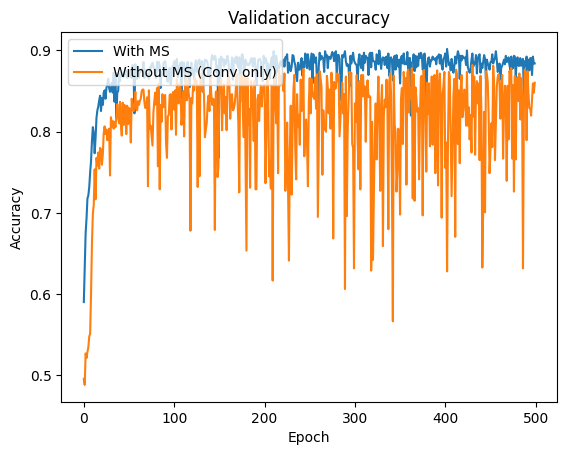

In [11]:
from matplotlib import pyplot as plt
plt.plot(history1.history['val_avg_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With MS', 'Without MS (Conv only)'], loc='upper left')
plt.show()